Data: Credit Card Fraud Detection - Kaggle
<br /><br />
As said in the data description, it is skewed i.e. classes are highlyimbalanced, class-1 i.e. fraud transactions are very few. For us, model sensitivity (TP/Actual Positive) and precision (TP/predicted positive) are really important metrics.
<br /><br />
This example uses "Naive Bayes" that is simple but powerful algorithm for predictive modeling and classification.
<br /><br />
Naive Bayes Algorithms:
<br /><br />
P(h|d) = P(d|h)*P(h) / P(d)

<br />
where P(h|d) is "posterior probability" = prob. of hypothesis h for given data d, P(d|h) is the prob. of data d given hypothesis h is true, P(h) "prior prob of h" being true regardless of data, P(d) prob. of data regardless of hypo.
<br /><br />
Calculate posterior prob. for a number of hypo., select the one with highest prob. This maximum probable hypothesis is called MAP (maximum a posteriori): MAP(h) = max(P(h|d)) or max(P(d|h)P(h)) / P(d) or max(P(d|h)P(h)),
<br /><br />
( given P(d) is constant, only used for normalization, so can be dropped).
<br /><br />
Strong assumption: all the features are independent of each other => P(d1|h) P(d2|h) ... so on
<br /><br />
A learned naive bayes model stores a list of probabilities:

1. prob. for each class in the training dataset: class prob.
2. the conditional prob. for each input value given each class value: cond. prob.

Note that training is fast because it saves only prob. values listed above, no coeffi. need to be fitted by optimization procedures.
<br /><br />
Gaussian Naive Bayes:

- real-valued attributes estimated by assuming a Gaussian distribution.
- easiest to work with, only need mean and std from training data
- calculate mean and std of input values(X) for each class to summarize the distr.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,auc,roc_auc_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

In [2]:
# Data Handling: Load CSV
df = pd.read_csv("creditcard.csv")

# get to know list of features, data shape, stat. description.
print(df.shape)

print("First 5 lines:")
print(df.head(5))

print("describe: ")
print(df.describe())

print("info: ")
print(df.info())

# Since all variables are of float and int type, so this data is easy to handle for modeling

(284807, 31)
First 5 lines:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

    

Class as pie chart:


Text(0, 0.5, '')

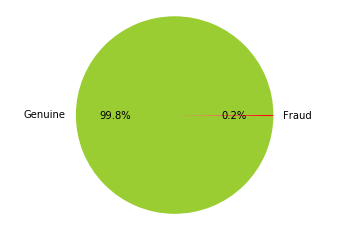

In [3]:
# Check Class variables that has 0 value for Genuine transactions and 1 for Fraud
print("Class as pie chart:")
fig, ax = plt.subplots(1, 1)
ax.pie(df.Class.value_counts(),autopct='%1.1f%%', labels=['Genuine','Fraud'], colors=['yellowgreen','r'])
plt.axis('equal')
plt.ylabel('')

Time variable
284802    47.996111
284803    47.996389
284804    47.996667
284805    47.996667
284806    47.997778
Name: Time_Hr, dtype: float64


Text(0, 0.5, '# transactions')

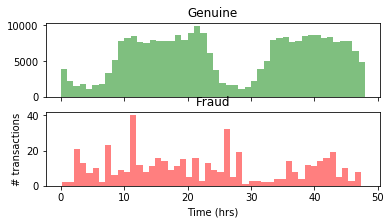

In [4]:
#plot Time to see if there is any trend
print("Time variable")
df["Time_Hr"] = df["Time"]/3600 # convert to hours
print(df["Time_Hr"].tail(5))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(6,3))
ax1.hist(df.Time_Hr[df.Class==0],bins=48,color='g',alpha=0.5)
ax1.set_title('Genuine')
ax2.hist(df.Time_Hr[df.Class==1],bins=48,color='r',alpha=0.5)
ax2.set_title('Fraud')
plt.xlabel('Time (hrs)')
plt.ylabel('# transactions')

This "Time" feature shows that rate of transactions is picking up during day time. But number of transactions have almost similar dependence on time of the day for both the classes. So, it is believed that this feature does not yield any predictive power to distinguish between the two classes. But of course we will later test this assumption. For now, let's keep this feature in data frame. Drop "Time" but keep "Time_Hr".

In [5]:
df = df.drop(['Time'],axis=1)

Text(0, 0.5, '# transactions')

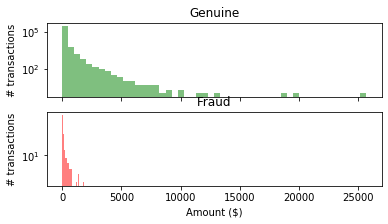

In [6]:
#let us check another feature Amount
fig, (ax3,ax4) = plt.subplots(2,1, figsize = (6,3), sharex = True)
ax3.hist(df.Amount[df.Class==0],bins=50,color='g',alpha=0.5)
ax3.set_yscale('log') # to see the tails
ax3.set_title('Genuine') # to see the tails
ax3.set_ylabel('# transactions')
ax4.hist(df.Amount[df.Class==1],bins=50,color='r',alpha=0.5)
ax4.set_yscale('log') # to see the tails
ax4.set_title('Fraud') # to see the tails
ax4.set_xlabel('Amount ($)')
ax4.set_ylabel('# transactions')

"all transaction amounts > 10K in Genuine Class only", also this amount feature is not on same scale as principle components. So, we standardize the values of the 'Amount' feature using StandardScalar and save in data-frame for later use.

In [7]:
from sklearn.preprocessing import StandardScaler
df['scaled_Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df = df.drop(['Amount'],axis=1)

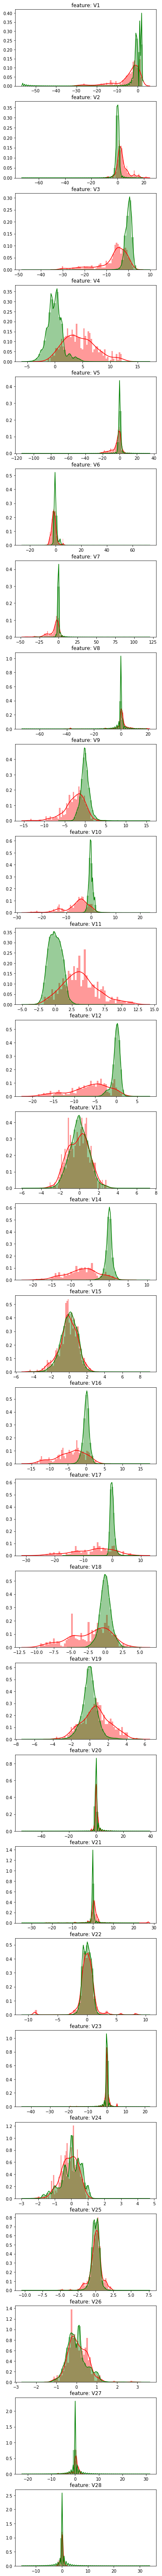

In [8]:
#let us check correlations and shapes of those 25 principal components.
# Features V1, V2, ... V28 are the principal components obtained with PCA.
import seaborn as sns
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(28, 1)
plt.figure(figsize=(6,28*4))
for i, col in enumerate(df[df.iloc[:,0:28].columns]):
    ax5 = plt.subplot(gs[i])
    sns.distplot(df[col][df.Class == 1], bins=50, color='r')
    sns.distplot(df[col][df.Class == 0], bins=50, color='g')
    ax5.set_xlabel('')
    ax5.set_title('feature: ' + str(col))
plt.show()

For some of the features, both the classes have similar distribution. So, perhaps they do not contribute towards classifying power of the model. So, it's best to drop them and reduce the model complexity, and hence the chances of overfitting. We will stilll check the validity of above argument later.

#### Split Data

In [9]:
def split_data(df, drop_list):
    df = df.drop(drop_list,axis=1)
    print(df.columns)
    #test train split time
    from sklearn.model_selection import train_test_split
    y = df['Class'].values #target
    X = df.drop(['Class'],axis=1).values #features
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

    print("train-set size: ", len(y_train),
      "\ntest-set size: ", len(y_test))
    print("fraud cases in test-set: ", sum(y_test))
    return X_train, X_test, y_train, y_test

Below is funtion to define classifier and get predictions. We can use "predict()" method that checks whether a record should belong to "Fraud" or "Genuine" class. There is another method "predict_proba()" that gives the probabilities for each class. It helps us to learn the idea of changing the threshold that assigns an instance to class 1 or 0, thus we can control precision and recall scores. This would be used to calculate area under ROC.

In [10]:
def get_predictions(clf, X_train, y_train, X_test):
    # create classifier
    clf = clf
    # fit it to training data
    clf.fit(X_train,y_train)
    # predict using test data
    y_pred = clf.predict(X_test)
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = clf.predict_proba(X_test)
    #for fun: train-set predictions
    train_pred = clf.predict(X_train)
    print('train-set confusion matrix:\n', confusion_matrix(y_train,train_pred)) 
    return y_pred, y_pred_prob

Function to print the classifier's scores

In [11]:
def print_scores(y_test,y_pred,y_pred_prob):
    print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred)) 
    print("recall score: ", recall_score(y_test,y_pred))
    print("precision score: ", precision_score(y_test,y_pred))
    print("f1 score: ", f1_score(y_test,y_pred))
    print("accuracy score: ", accuracy_score(y_test,y_pred))
    print("ROC AUC: {}".format(roc_auc_score(y_test, y_pred_prob[:,1])))

some of features above have very similar shapes for the two types of transactions, so it is believed that dropping them should help to reduce the model complexity and thus increase the classifier sensitivity.
<br /><br />
Let us check this with dropping some of the features and checking scores.

In [12]:
from sklearn.naive_bayes import GaussianNB

# Case-NB-1 : do not drop anything
drop_list = []
X_train, X_test, y_train, y_test = split_data(df, drop_list)
y_pred, y_pred_prob = get_predictions(GaussianNB(), X_train, y_train, X_test)
print_scores(y_test,y_pred,y_pred_prob)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'Time_Hr',
       'scaled_Amount'],
      dtype='object')
train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
train-set confusion matrix:
 [[222480   4971]
 [    69    325]]
test-set confusion matrix:
 [[55535  1329]
 [   15    83]]
recall score:  0.8469387755102041
precision score:  0.058781869688385266
f1 score:  0.10993377483443707
accuracy score:  0.9764053228468101
ROC AUC: 0.963247971529636


In [13]:
# Case-NB-2 : drop some of principle components that have similar distributions in above plots 
drop_list = ['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8']
X_train, X_test, y_train, y_test = split_data(df, drop_list)
y_pred, y_pred_prob = get_predictions(GaussianNB(), X_train, y_train, X_test)
print_scores(y_test,y_pred,y_pred_prob)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12',
       'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'Class', 'Time_Hr',
       'scaled_Amount'],
      dtype='object')
train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
train-set confusion matrix:
 [[223967   3484]
 [    61    333]]
test-set confusion matrix:
 [[55935   929]
 [   12    86]]
recall score:  0.8775510204081632
precision score:  0.08472906403940887
f1 score:  0.15453728661275834
accuracy score:  0.9834802148800955
ROC AUC: 0.9622034097825962


Clearly, by removing some of the reduntant principle components, we gain in model sensitivity and precision.

In [14]:
# Case-NB-3 : drop some of principle components + Time 
drop_list = ['Time_Hr','V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8']
X_train, X_test, y_train, y_test = split_data(df, drop_list)
y_pred, y_pred_prob = get_predictions(GaussianNB(), X_train, y_train, X_test)
print_scores(y_test,y_pred,y_pred_prob)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12',
       'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'Class', 'scaled_Amount'],
      dtype='object')
train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
train-set confusion matrix:
 [[223964   3487]
 [    60    334]]
test-set confusion matrix:
 [[55936   928]
 [   12    86]]
recall score:  0.8775510204081632
precision score:  0.08481262327416174
f1 score:  0.15467625899280577
accuracy score:  0.9834977704434535
ROC AUC: 0.9613612643988377


As we can see by comapring Case-NB-3 scores with Case-NB-2 scores, "Time_Hr" is not helping much in classification. So, we can remove it safely.

In [15]:
# Case-NB-4 : drop some of principle components + Time + 'scaled_Amount'
drop_list = ['scaled_Amount','Time_Hr','V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8']
X_train, X_test, y_train, y_test = split_data(df, drop_list)
y_pred, y_pred_prob = get_predictions(GaussianNB(), X_train, y_train, X_test)
print_scores(y_test,y_pred,y_pred_prob)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12',
       'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'Class'],
      dtype='object')
train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
train-set confusion matrix:
 [[224025   3426]
 [    60    334]]
test-set confusion matrix:
 [[55954   910]
 [   12    86]]
recall score:  0.8775510204081632
precision score:  0.08634538152610442
f1 score:  0.15722120658135283
accuracy score:  0.9838137705838981
ROC AUC: 0.9611556179872063


Overall, Case-NB-4 gives better model sensitivity (or recall) and precision as compared to Case-NB-1. So dropping some of redundant feature will help to make calculations fast and gain sensitivity.

In [16]:
df = df.drop(drop_list,axis=1)
print(df.columns)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12',
       'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'Class'],
      dtype='object')
